In [75]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from river import anomaly, preprocessing, compose, ensemble, neighbors, datasets
from river.utils import numpy2dict
from math import ceil, floor

In [50]:
'''
EXTERNAL KERNEL
'''
google_colab = False
kaggle = False

'''
CUDA
'''
cuda = False

'''
DATA REPRESENTATION

1 => SINGLE READ | 2 => ADD FEATURES | 3 => WINDOW TO FEATURES
'''
DATA_REPRESENTATION = 3

'''
DOWNSAMPLE FACTOR

1 => 10hz *original rate* | 2 => 5Hz | 5 => 2Hz | 10 => 1hz
'''
DOWNSAMPLE_FACTOR = 5

'''
WINDOWS LENGHT

* needs divisor by datapoints target
* considering downsample factor = 5

1 => WINDOW DISABLED | 2 => 1 second | 4 => 2 seconds | 10 => 5 seconds | 20 => 10 seconds | 200 => 100 seconds *full flight*
'''
WINDOW_LENGHT =  10

'''
LIMITADOR

Quantity of samples in the execution of the tests.
'''
LIMITADOR = 5000

'''
LOSS FACTOR [0,1]

Ignores outliers in calculating the stats of losses in regenerated data.
'''
LOSS_FACTOR = 1

'''
TRAIN_SIZE [0,1]

Percentage of samples to be trained
'''
TRAIN_SIZE = 0.8

'''
OUTPUT_FILE_NAME

File with output results
'''
OUTPUT_FILE_NAME = 'output_hst_river_dr_' + str(DATA_REPRESENTATION) + '-ts_' + str(TRAIN_SIZE) + '-lf_' + str.replace(str(LOSS_FACTOR), '.', '') + '-limit_' + str(LIMITADOR) + '-wl_' + str(WINDOW_LENGHT) + '.txt'

'''
PATH_OUTPUTS

'''
PATH_OUTPUTS = './outputs/'

'''
PATH_DATASET

'''
PATH_DATASET = '../../dataset/original/'

'''
FLUSH FILE

If output results file is ON
'''
FLUSH_FILE = False

In [54]:
if google_colab:
    from google.colab import drive

    drive.mount('/content/drive')
    path = '/content/drive/My Drive/ACADÊMICO/MESTRADO/DISSERTAÇÃO/CHAPTERS/5 EXPERIMENTO/dataset/data_representation_1'
    dict_ds_original = {
        'data_ds3_normal_t1_original' : pd.read_csv(path+'/F16_DS3_normal_t1.csv', header=None),
        'data_ds3_normal_t2_original' : pd.read_csv(path+'/F16_DS3_normal_t2.csv', header=None),
        'data_ds3_fault1_original' : pd.read_csv(path+'/F16_DS3_fault1_leakage.csv', header=None),
        'data_ds3_fault2_original' : pd.read_csv(path+'/F16_DS3_fault2_viscousfriction.csv', header=None),
        'data_ds3_fault3_original' : pd.read_csv(path+'/F16_DS3_fault3_compressibility.csv', header=None),
        'data_ds3_fault4_original' : pd.read_csv(path+'/F16_DS3_fault4_fixedposition.csv', header=None),
    }
elif kaggle:
    !conda install -y gdown
    !gdown --id 1G88okIVmdcgLFlmd7rDRhHvHv98yK3UB
    !gdown --id 1fX3utfHMjwKTt7IW4D01bnm-hv88yzrJ
    !gdown --id 1yUG3R5zK2AIxtS9Q4Fk-udkKBZeYShgb
    !gdown --id 1OBRDtuqNEZ-3Z-q0helWh2xGiAxeLACH
    !gdown --id 17oDi60sWYsWHHxzj2aA9m6ARm8zQ81m_
    !gdown --id 1jKEK4s5sYJh8PHtpHeV8ABOsHjuB26RA
else:
    dict_ds_original = {
        'data_ds3_normal_t1_original' : pd.read_csv(PATH_DATASET+'F16_DS3_normal_t1.csv', header=None),
        'data_ds3_normal_t2_original' : pd.read_csv(PATH_DATASET+'F16_DS3_normal_t2.csv', header=None),
        'data_ds3_fault1_original' : pd.read_csv(PATH_DATASET+'F16_DS3_fault1_leakage.csv', header=None),
        'data_ds3_fault2_original' : pd.read_csv(PATH_DATASET+'F16_DS3_fault2_viscousfriction.csv', header=None),
        'data_ds3_fault3_original' : pd.read_csv(PATH_DATASET+'F16_DS3_fault3_compressibility.csv', header=None),
        'data_ds3_fault4_original' : pd.read_csv(PATH_DATASET+'F16_DS3_fault4_fixedposition.csv', header=None),
    }

In [56]:
dict_ds = dict_ds_original.copy()

if dict_ds['data_ds3_normal_t1_original'].shape[0] % DOWNSAMPLE_FACTOR != 0 or dict_ds['data_ds3_fault1_original'].shape[0] % DOWNSAMPLE_FACTOR != 0:
    raise Exception('Needs to be ?shape? divisor')

for n, dataset_name in enumerate(dict_ds):
    dataset = dict_ds[dataset_name].to_numpy()

    downsampled = dataset[::DOWNSAMPLE_FACTOR]

    x, y = downsampled.shape

    # resample
    dict_ds[dataset_name] = pd.DataFrame(downsampled.reshape((int(x/WINDOW_LENGHT),y*WINDOW_LENGHT)))


In [57]:
# ADD COLUMNS WITH DIFF PREVIOUS VALUES

if (DATA_REPRESENTATION == 2):
    frame_size = int(1000/DOWNSAMPLE_FACTOR)

    for n, dataset_name in enumerate(dict_ds):
        dataset = dict_ds[dataset_name].to_numpy()

        dimension = dataset.shape[1]
        samples = dataset.shape[0]

        # GENERATE NEW DIMENSIONS
        dataset = np.concatenate((dataset, np.zeros((samples,dimension))), axis=1)

        for f in np.arange(0,int(samples/frame_size)):
            # OBTAIN THE FRAME FLIGHT
            frame = dataset[f*frame_size:(f+1)*frame_size, 0:dimension]

            # CALCULATE DIFFERENCE
            chunk = np.diff(frame, axis=0)

            # DONT CALCULATE THE DIFFERENCE FOR EACH FIRST TIMESTEP
            chunk = np.insert(chunk, 0, frame[0, 0:dimension], axis=0)

            # UPDATE DATASET WITH NEW FRAME INTO NEW DIMENSIONS
            dataset[f*frame_size:(f+1)*frame_size,dimension:dimension*2] = chunk

        dict_ds[dataset_name] = pd.DataFrame(dataset)



In [58]:
#ss = StandardScaler()
ss = MinMaxScaler()

data_ds3_t1_normal = dict_ds['data_ds3_normal_t1_original']
data_ds3_t2_normal = dict_ds['data_ds3_normal_t2_original']
data_ds3_fault1 = dict_ds['data_ds3_fault1_original']
data_ds3_fault2 = dict_ds['data_ds3_fault2_original']
data_ds3_fault3 = dict_ds['data_ds3_fault3_original']
data_ds3_fault4 = dict_ds['data_ds3_fault4_original']

# fit values
ss.partial_fit(data_ds3_t1_normal)
ss.partial_fit(data_ds3_t2_normal)
ss.partial_fit(data_ds3_fault1)
ss.partial_fit(data_ds3_fault2)
ss.partial_fit(data_ds3_fault3)
ss.partial_fit(data_ds3_fault4)

# transform values
data_ds3_t1_normal = ss.transform(data_ds3_t1_normal)
data_ds3_t2_normal = ss.transform(data_ds3_t2_normal)
data_ds3_fault1 = ss.transform(data_ds3_fault1)
data_ds3_fault2 = ss.transform(data_ds3_fault2)
data_ds3_fault3 = ss.transform(data_ds3_fault3)
data_ds3_fault4 = ss.transform(data_ds3_fault4)

# append normal labels
data_ds3_t1_normal = np.append(data_ds3_t1_normal, np.zeros((data_ds3_t1_normal.shape[0],1)), axis = 1)
data_ds3_t2_normal = np.append(data_ds3_t2_normal, np.zeros((data_ds3_t2_normal.shape[0],1)), axis = 1)

# append fault labels
def generate_fault_label(dataset, fault_label):
    labels = np.array([[fault_label]]*dataset.shape[0])

    return labels

data_ds3_fault1 = np.append(data_ds3_fault1, generate_fault_label(data_ds3_fault1, 1), axis = 1)
data_ds3_fault2 = np.append(data_ds3_fault2, generate_fault_label(data_ds3_fault2, 2), axis = 1)
data_ds3_fault3 = np.append(data_ds3_fault3, generate_fault_label(data_ds3_fault3, 3), axis = 1)
data_ds3_fault4 = np.append(data_ds3_fault4, generate_fault_label(data_ds3_fault4, 4), axis = 1)

In [125]:
def verify_inliers(model, inliers, threshold):
    inliers_detected = 0
    scores = []
    for k, x in enumerate(inliers):
        score = model.score_one(numpy2dict(x))
        scores.append(score)
        if (score <= threshold): #low score - normal observation
            inliers_detected = inliers_detected+1

    value = inliers_detected/len(inliers)*100
    return value, scores

def verify_outliers(model, outliers, threshold):
    outliers_detected = 0

    for k, x in enumerate(outliers):
        score = model.score_one(numpy2dict(x))

        if (score > threshold): #high score - outlier observation
            outliers_detected = outliers_detected+1

    value = outliers_detected/len(outliers)*100
    return value

columns = ['NORMAL_1_TEST', 'NORMAL_2', 'F1', 'F2', 'F3', 'F4']


In [60]:
X_train, X_test, y_train, y_test = train_test_split(data_ds3_t1_normal[:, :-1], data_ds3_t1_normal[:, -1], test_size=1-TRAIN_SIZE, random_state=42)

In [127]:
log = None
if FLUSH_FILE:
    log = open(PATH_OUTPUTS+OUTPUT_FILE_NAME, "a", buffering=1)

'''
Hyperparameters
'''
n = 20 # n_trees
h = 4 # height
ws = 100 # window size
t = 0.1 # threshold

'''
Increment Parameters
'''
increments = 10
block_size = int(floor(len(X_train) / increments))

'''
Model
'''
clf = compose.Pipeline(anomaly.HalfSpaceTrees(n_trees=n, height=h, window_size=ws, seed=42))

p = 0
for c, x in enumerate(X_train):
    clf.learn_one(numpy2dict(x))

    r = np.zeros((1, 6))
    if c % block_size == 0:

        r[0][0], scores = verify_inliers(clf, X_test, t) #n1
        print(np.mean(scores), np.std(scores, ddof=1))
        t = np.mean(scores) + np.std(scores, ddof=1)
        r[0][1], _ = verify_inliers(clf, data_ds3_t2_normal, t) #n2
        r[0][2] = verify_outliers(clf, data_ds3_fault1[:LIMITADOR, :-1], t) #f1
        r[0][3] = verify_outliers(clf, data_ds3_fault2[:LIMITADOR, :-1], t) #f2
        r[0][4] = verify_outliers(clf, data_ds3_fault3[:LIMITADOR, :-1], t) #f3
        r[0][5] = verify_outliers(clf, data_ds3_fault4[:LIMITADOR, :-1], t) #f4

        if p == 0:
            output = np.zeros((1, 6))
            output[0] = r
        else:
            output = np.append(output, r, axis=0)

        p = p+1

if FLUSH_FILE:
    log.close()

0.0 0.0
0.0 0.0
0.10039605734767025 0.03410722280465778
0.09892437275985663 0.03416738090295307
0.09892437275985663 0.03416738090295307
0.0959673835125448 0.035191339596001445
0.09819749103942653 0.035312885545397715
0.09853225806451617 0.035159195412105736
0.09853225806451617 0.035159195412105736
0.09517383512544804 0.03604058703863733


In [123]:
out = pd.DataFrame(output, columns=columns)
out

,NORMAL_1,NORMAL_2,F1,F2,F3,F4
0,100.000000,100.000000,0.0,0.0,0.0,0.0
1,100.000000,100.000000,0.0,0.0,0.0,0.0
2,57.222222,51.888889,82.4,100.0,97.0,100.0
3,59.444444,52.444444,83.8,100.0,97.0,100.0
4,59.444444,52.444444,83.8,100.0,97.0,100.0
5,60.555556,53.333333,82.4,100.0,93.4,100.0
6,56.111111,52.555556,84.2,100.0,93.4,100.0
7,56.111111,52.444444,83.8,100.0,93.4,100.0
8,56.111111,52.444444,83.8,100.0,93.4,100.0
9,57.777778,52.666667,82.4,100.0,93.4,100.0


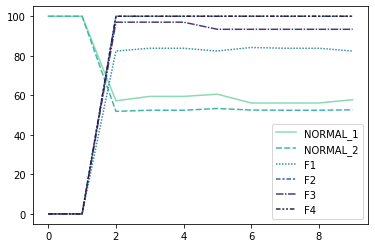

In [124]:
import seaborn as sns


sns.lineplot(data=out, palette=sns.color_palette("mako_r", 6), legend="full")